In [29]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as utils
import os
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter()

In [ ]:
import random
# Set the random seed for reproducibility anywhere
random.seed(101)
torch.manual_seed(101)
np.random.seed(101)

def build_resnet18(num_classes, pretrained=True, device='cuda'):
    # Step 1: Load the pre-trained ResNet-18 model
    resnet18 = models.resnet18(pretrained=pretrained)

    # Modify input layer for 3-channel images
    ''' RESNET INPUT SHOULBE HAVE 3 CHANNELS SINCE ITS CONV1 WEIGHT IS PRETRAINED IN 3 CHANNELS '''
    resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Step 2: Modify the fully connected layer for digit classification
    num_ftrs = resnet18.fc.in_features
    resnet18.fc = torch.nn.Linear(num_ftrs, num_classes)

    # Add softmax layer
    resnet18.softmax = nn.Softmax(dim=1)

    # Transfer the model tensor to CPU or GPU
    resnet18.to(device)

    return resnet18

# Example usage:
num_classes = 10  # Number of classes for digit classification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = build_resnet18(num_classes=num_classes, pretrained=True, device= device)

# Print the modified model
print(f"\n Training on {device} \n \n", resnet18)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Print the shape of the weight tensor
# print(resnet_model.conv1.weight.shape)
# print(resnet_model.conv1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]



 Training on cuda 
 
 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu)

# **Load using my custom pretrained weights**

In [ ]:

# custom_weights_path = 'path/to/your/pretrained_weights.pth'
# custom_weights = torch.load(custom_weights_path)

# # Initialize ResNet-18 with custom pretrained weights
# resnet18 = models.resnet18(pretrained=False)
# resnet18.load_state_dict(custom_weights)

In [30]:
from torchvision.datasets import MNIST, SVHN


'''SINCE MNIST ONLY GIVES 1-CHANNEL, WE TRANSFORM TO PRODUCE 3 CHANNEL FOR OUR RESNET18 EXPECTED INPUT '''

# Define data transformations for standardizing input images
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size

    transforms.Grayscale(num_output_channels=3),  # Convert images to 3-channel grayscale
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values
])

# # Create data loaders for MNIST and SVHN with standardized transformations

# Load the MNIST dataset
mnist_train_set_ = datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)
svhn_train_set_ = datasets.SVHN(root='./data', split='train', download=True, transform=data_transforms)


def get_mnist_svhn_loaders(mnist_train_size=6000, mnist_test_size=2000, svhn_train_size=6000, svhn_test_size=2000, batch_size=64):
    # Define data transformations for standardizing input images
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to a consistent size
        transforms.Grayscale(num_output_channels=3),  # Convert images to 3-channel grayscale
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values
    ])

    # Load the MNIST dataset
    mnist_train_set = datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)
    mnist_test_set = datasets.MNIST(root='./data', train=False, download=True, transform=data_transforms)

    # Subset the MNIST datasets
    mnist_train_subset = Subset(mnist_train_set, list(range(mnist_train_size)))
    mnist_test_subset = Subset(mnist_test_set, list(range(mnist_test_size)))

    # Create data loaders for MNIST
    mnist_train_loader = DataLoader(mnist_train_subset, batch_size=batch_size, shuffle=True)
    mnist_test_loader = DataLoader(mnist_test_subset, batch_size=batch_size, shuffle=False)

    # Load the SVHN dataset
    svhn_train_set = datasets.SVHN(root='./data', split='train', download=True, transform=data_transforms)
    svhn_test_set = datasets.SVHN(root='./data', split='test', download=True, transform=data_transforms)

    # Subset the SVHN datasets
    svhn_train_subset = Subset(svhn_train_set, list(range(svhn_train_size)))
    svhn_test_subset = Subset(svhn_test_set, list(range(svhn_test_size)))

    # Create data loaders for SVHN
    svhn_train_loader = DataLoader(svhn_train_subset, batch_size=batch_size, shuffle=True)
    svhn_test_loader = DataLoader(svhn_test_subset, batch_size=batch_size, shuffle=False)

    return mnist_train_subset, mnist_test_subset, mnist_train_loader, mnist_test_loader, svhn_train_subset, svhn_test_subset, svhn_train_loader, svhn_test_loader


mnist_train_set, mnist_test_set, mnist_train_loader, mnist_test_loader, svhn_train_set, svhn_test_set, svhn_train_loader, svhn_test_loader = get_mnist_svhn_loaders()


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat


100%|██████████| 64275384/64275384 [00:13<00:00, 4631214.45it/s]


In [ ]:
# Numbers of items or length of the datasets and dataloaders
print(f"MNIST Train dataSet size is: {len(mnist_train_set)}, with Test dataset Size: {len(mnist_test_set)}  \n")
print(f"SVHN Train dataet Size is: {len(svhn_train_set)} with Test dataset Size: {len(svhn_train_loader)}\n")

MNIST Train dataSet size is: 6000, with Test dataset Size: 2000  

SVHN Train dataet Size is: 6000 with Test dataset Size: 94



In [ ]:

class Trainer:
    def __init__(self, model, train_loader, test_loader, optimizer, criterion, device, num_epochs=5, log_dir='logs', checkpoint_interval=3, set_name='mnist'):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.num_epochs = num_epochs
        self.log_dir = log_dir
        self.set_name = set_name
        self.checkpoint_interval = checkpoint_interval

        # Create a unique log directory for each instance
        self.writer = SummaryWriter(os.path.join(self.log_dir, f'run_{len(os.listdir(self.log_dir)) + 1}'))

    def train_and_evaluate(self):
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            self.model.train()

            for i, data in enumerate(self.train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                # loss = self.criterion(outputs, labels)

                # Apply softmax to the model outputs
                outputs_softmax = F.softmax(outputs, dim=1)

                loss = self.criterion(outputs_softmax, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            # Log the training loss to TensorBoard
            epoch_loss = running_loss / len(self.train_loader)
            self.writer.add_scalar(' Training Loss', epoch_loss, epoch + 1)
            print(f"Epoch {epoch + 1}, Training Loss: {epoch_loss}")

            # Save model checkpoint
            if (epoch + 1) % self.checkpoint_interval == 0:
                self.save_checkpoint(epoch + 1)

            # Evaluate and log accuracy on the test set
            accuracy = self.evaluate(epoch + 1)

    def evaluate(self, epoch):
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)

                # Apply softmax to the model outputs
                outputs_softmax = F.softmax(outputs, dim=1)

                _, predicted = torch.max(outputs_softmax.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch}, Accuracy on the test set: {accuracy}%')

        # Log the accuracy to TensorBoard
        self.writer.add_scalar('Validation Accuracy', accuracy, epoch)

        return accuracy

    def save_checkpoint(self, epoch):
        checkpoint_path = os.path.join(self.log_dir, f'{self.set_name}_checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            # Add other necessary information
        }, checkpoint_path)

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f"Loaded checkpoint from epoch {epoch}")

    def close_writer(self):
        self.writer.close()


class Display_Prediction:
    def __init__(self, model, test_loader, device):
        self.model = model
        self.test_loader = test_loader
        self.device = device

    def display_sample_predictions(self, num_samples=4):
        self.model.eval()

        # Collect predictions and ground truth labels for the specified number of samples
        sample_predictions = []

        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)

                for i in range(images.size(0)):
                    sample_predictions.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))

                if len(sample_predictions) >= num_samples:
                    break

        # Display predictions for the collected samples in a 2x2 grid
        num_rows = num_samples // 2  # Assuming num_samples is even
        fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5))

        for i, (image, predicted, label) in enumerate(sample_predictions[:num_samples]):
            row = i // 2
            col = i % 2
            self.plot_single_prediction(image, predicted, label, axes[row, col])

        plt.tight_layout()
        plt.show()

    def plot_single_prediction(self, image, predicted, label, ax):
        # Plot and display a single prediction in a specific subplot
        ax.imshow(image[0].numpy(), cmap='gray')
        ax.set_title(f'Predicted: {predicted.item()}, Actual: {label.item()}')
        ax.axis('off')


Text(0, 0.5, 'Number of Samples')

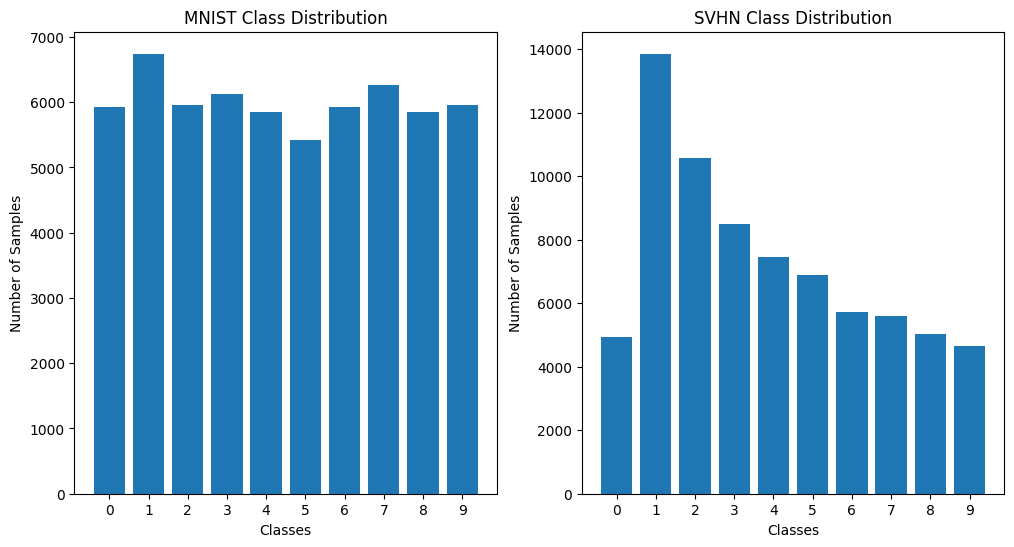

In [ ]:
'''
To visualize the class distribution and determine if the dataset is balanced
'''

# Obtain class labels from the transformed MNIST and SVHN dataset and pass them as labels
labels = mnist_train_set_.targets.numpy()
svhn_labels = svhn_train_set_.labels

# Calculate the class distribution
mnist_class_counts = np.bincount(labels)
svhn_class_counts = np.bincount(svhn_labels)

# Visualize the histogram of class distribution for both datasets
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].bar(range(len(mnist_class_counts)), mnist_class_counts, tick_label=range(len(mnist_class_counts)))
axes[0].set_title('MNIST Class Distribution')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Samples')

axes[1].bar(range(len(svhn_class_counts)), svhn_class_counts, tick_label=range(len(svhn_class_counts)))
axes[1].set_title('SVHN Class Distribution')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Samples')

# **CLASS DISTRIBUTION FOR THE SAMPLED 6000 MNIST AND SVHN DATASETS**

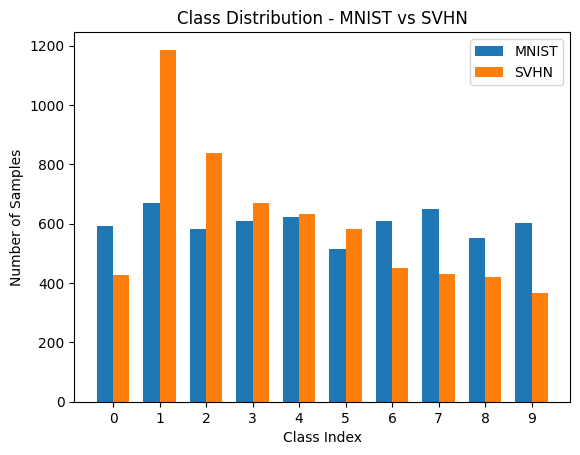

In [ ]:
import matplotlib.pyplot as plt

# Count the number of samples for each class in both datasets
num_classes = 10  # Assuming both MNIST and SVHN have 10 classes

mnist_class_counts = [0] * num_classes
svhn_class_counts = [0] * num_classes

for _, label in mnist_train_set:
    mnist_class_counts[label] += 1

for _, label in svhn_train_set:
    svhn_class_counts[label] += 1

# Plot the class distribution
class_indices = list(range(num_classes))
bar_width = 0.35

plt.bar(class_indices, mnist_class_counts, width=bar_width, label='MNIST')
plt.bar([i + bar_width for i in class_indices], svhn_class_counts, width=bar_width, label='SVHN')

plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.title('Class Distribution - MNIST vs SVHN')
plt.xticks([i + bar_width / 2 for i in class_indices], class_indices)
plt.legend()

plt.show()

In [ ]:
# Trainer class with a specific log directory
MNIST_trainer = Trainer(resnet18, mnist_train_loader, mnist_test_loader, optimizer, criterion, device, num_epochs=20, log_dir='runs', checkpoint_interval=5)

# Train and evaluate the model
MNIST_trainer.train_and_evaluate()

# Save model at interval
MNIST_trainer.save_checkpoint(MNIST_trainer.num_epochs)

# Close the TensorBoard writer
MNIST_trainer.close_writer()


Epoch 1, Training Loss: 1.5408982076543443
Epoch 1, Accuracy on the test set: 91.1%
Epoch 2, Training Loss: 1.4861254933032584
Epoch 2, Accuracy on the test set: 96.6%
Epoch 3, Training Loss: 1.484880656638044
Epoch 3, Accuracy on the test set: 96.0%
Epoch 4, Training Loss: 1.4827090045239062
Epoch 4, Accuracy on the test set: 89.75%
Epoch 5, Training Loss: 1.478135808985284
Epoch 5, Accuracy on the test set: 97.65%
Epoch 6, Training Loss: 1.473882033469829
Epoch 6, Accuracy on the test set: 97.1%
Epoch 7, Training Loss: 1.4747704039228724
Epoch 7, Accuracy on the test set: 97.7%
Epoch 8, Training Loss: 1.4741045731179259
Epoch 8, Accuracy on the test set: 97.25%
Epoch 9, Training Loss: 1.471408613184665
Epoch 9, Accuracy on the test set: 97.65%
Epoch 10, Training Loss: 1.4715846358461584
Epoch 10, Accuracy on the test set: 98.25%
Epoch 11, Training Loss: 1.4729338719489726
Epoch 11, Accuracy on the test set: 93.5%
Epoch 12, Training Loss: 1.4742575579501214
Epoch 12, Accuracy on the t

In [ ]:
# # Load the last saved checkpoint
# MNIST_trainer.load_checkpoint("logs/model_checkpoint_epoch_15.pth")

# # Resume training from the loaded checkpoint
# MNIST_trainer.train_and_evaluate()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

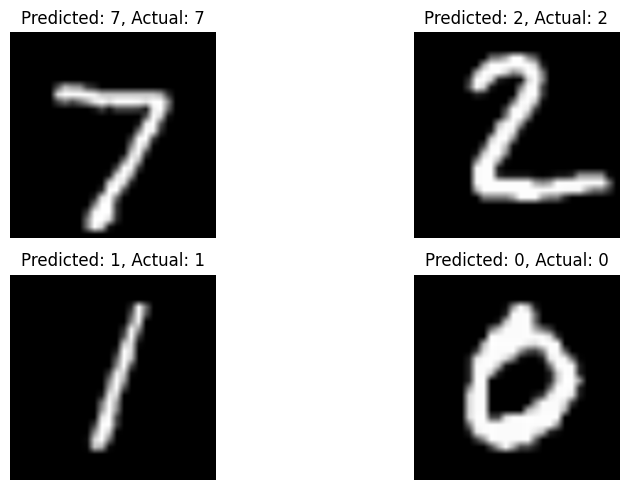

In [ ]:

# Prediction Displayer
prediction_displayer = Display_Prediction(resnet18, mnist_test_loader, device)

# Display sample predictions using the PredictionDisplayer class
prediction_displayer.display_sample_predictions()


In [ ]:
svhn_trainer = Trainer(resnet18, svhn_train_loader, svhn_test_loader, optimizer, criterion, device, num_epochs=20, log_dir='runs', set_name='SVHN' )

# Train and evaluate the model
svhn_trainer.train_and_evaluate()

# Close the TensorBoard writer
svhn_trainer.close_writer()

Epoch 1, Training Loss: 1.808913438878161
Epoch 1, Accuracy on the test set: 67.8%
Epoch 2, Training Loss: 1.7201715847279162
Epoch 2, Accuracy on the test set: 70.85%
Epoch 3, Training Loss: 1.6980088353157043
Epoch 3, Accuracy on the test set: 72.2%
Epoch 4, Training Loss: 1.6895067717166656
Epoch 4, Accuracy on the test set: 72.95%
Epoch 5, Training Loss: 1.6855484678390178
Epoch 5, Accuracy on the test set: 74.1%
Epoch 6, Training Loss: 1.678220455950879
Epoch 6, Accuracy on the test set: 76.35%
Epoch 7, Training Loss: 1.6699038426926796
Epoch 7, Accuracy on the test set: 75.15%
Epoch 8, Training Loss: 1.660521776118177
Epoch 8, Accuracy on the test set: 76.3%
Epoch 9, Training Loss: 1.6597949875162004
Epoch 9, Accuracy on the test set: 76.75%
Epoch 10, Training Loss: 1.6007559451651066
Epoch 10, Accuracy on the test set: 80.5%
Epoch 11, Training Loss: 1.5891506228041141
Epoch 11, Accuracy on the test set: 81.05%
Epoch 12, Training Loss: 1.586190974458735
Epoch 12, Accuracy on the 

In [ ]:

%tensorboard --logdir=runs

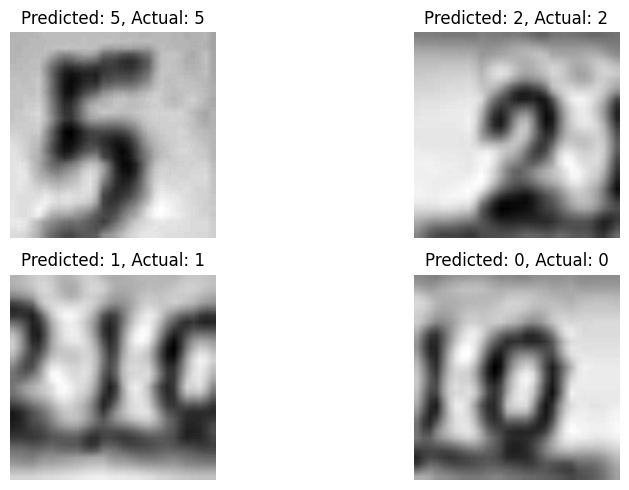

In [ ]:
# Prediction Displayer
prediction_displayer = Display_Prediction(resnet18, svhn_test_loader, device)

# Display sample predictions using the PredictionDisplayer class
prediction_displayer.display_sample_predictions()

In [ ]:
# Initialize ResNet-18 from scratch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)  # pretrained=False initializes the model with random weights
model.to(device)

# Modify the fully connected layer for digit classification
num_classes = 10  # Number of classes for digit classification
num_ftrs = resnet18.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)# Output layer for 10 classes
# Add softmax layer
model.softmax = nn.Softmax(dim=1)


# **SCRATCH RESNET18 TRAINED ON 6000 MNIST DATASET**

In [ ]:
MNIST_trainer_scratch = Trainer(resnet18, mnist_train_loader, mnist_test_loader, optimizer, criterion, device, num_epochs=20, log_dir='runs', checkpoint_interval=5, set_name='MNIST_SCRATCH')


# Train and evaluate the model
MNIST_trainer_scratch.train_and_evaluate()

# Close the TensorBoard writer
MNIST_trainer_scratch.close_writer()


Epoch 1, Training Loss: 1.5109298279944887
Epoch 1, Accuracy on the test set: 97.65%
Epoch 2, Training Loss: 1.4733657012594508
Epoch 2, Accuracy on the test set: 97.3%
Epoch 3, Training Loss: 1.4692499320557777
Epoch 3, Accuracy on the test set: 98.05%
Epoch 4, Training Loss: 1.4668213395362204
Epoch 4, Accuracy on the test set: 98.0%
Epoch 5, Training Loss: 1.4670777511089406
Epoch 5, Accuracy on the test set: 97.35%
Epoch 6, Training Loss: 1.4658937403496275
Epoch 6, Accuracy on the test set: 98.2%
Epoch 7, Training Loss: 1.4647338390350342
Epoch 7, Accuracy on the test set: 97.9%
Epoch 8, Training Loss: 1.4640992689639964
Epoch 8, Accuracy on the test set: 98.45%
Epoch 9, Training Loss: 1.4636376956675916
Epoch 9, Accuracy on the test set: 98.4%
Epoch 10, Training Loss: 1.4645850176506854
Epoch 10, Accuracy on the test set: 97.95%
Epoch 11, Training Loss: 1.4642731319082545
Epoch 11, Accuracy on the test set: 98.15%
Epoch 12, Training Loss: 1.4633155820217538
Epoch 12, Accuracy on 

In [ ]:
%tensorboard --logdir=runs

# **Get samples CycleGAN generated data : A**

In [36]:
!mkdir data
%cd data
!gdown https://drive.google.com/uc?id=16TdnYC1kCpKVR7yu8y8A-AvElvaQheOu


mkdir: cannot create directory ‘data’: File exists
/content/data/data
Downloading...
From: https://drive.google.com/uc?id=16TdnYC1kCpKVR7yu8y8A-AvElvaQheOu
To: /content/data/data/data_sem.npy
100% 23.5M/23.5M [00:00<00:00, 173MB/s]


# **Real colored data samples- convert MNIST to colored: B**

In [37]:
# convert MNIST to color images

'''
    Convert the digits to specific colored - version .
    0: red ; 1: blue ; 2: green ; 3: violet ; 4: purple ; 5: pink ;
    6: orange ; 7: yellow ; 8: brown ; 9: cornflower blue .
'''

def get_rgb(images_src, image_labels):
   colored_images = np.zeros((images_src.shape[0], 28, 28, 3))
   colors = np.array(
      [[255 , 0 , 0],
      [135 , 206 , 235],
      [ 0 , 128 , 0],
      [238 , 130 , 238],
      [128 , 0 , 128],
      [255 , 192 , 203],
      [255 , 128 , 0],
      [255 , 255 , 0],
      [165 , 42 , 42],
      [100 , 149 , 237]],np.float32)

   for k in range(images_src.shape[0]):
        for i in range(28):
            for j in range(28):
                if images_src[k][i][j]> 0:
                    colored_images[k][i][j][:] = colors[int(image_labels[k])]

   return colored_images

100%|██████████| 182040794/182040794 [00:36<00:00, 5024967.83it/s]


100%|██████████| 9912422/9912422 [00:00<00:00, 238177060.03it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110223561.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43540534.36it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4962367.48it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([64, 3, 28, 28])


torch.Size([64, 3, 28, 28])


<ipython-input-39-294cf6d4c6ce>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plotviews = torch.tensor(plotviews)


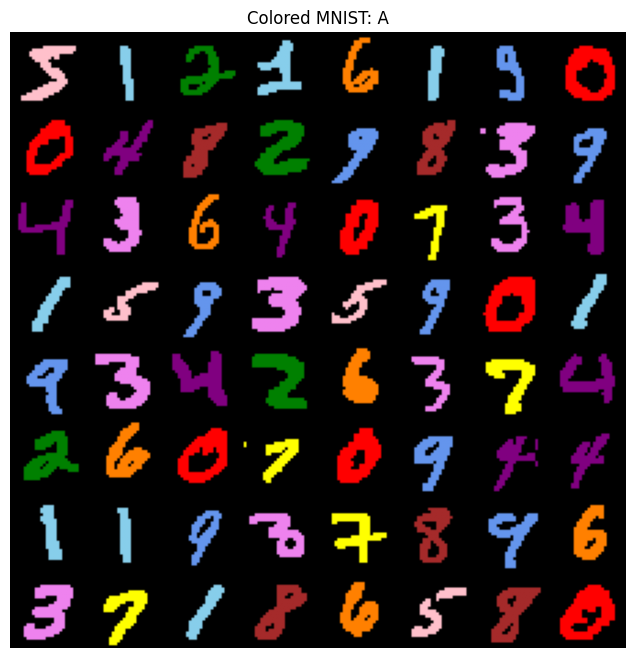

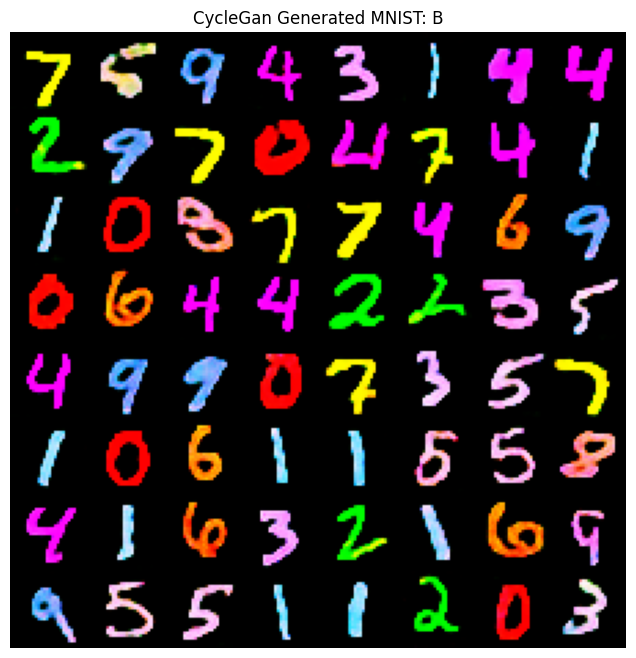

In [39]:
import torch
import torch.nn.functional as F
from scipy.linalg import sqrtm
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Create colored MNIST data #

# Dataset preparation
# number of images to process #
img_number = 1000
index_sub = np.arange(img_number)

# slicing SVHN dataset: Number of images to process
svhn_train = datasets.SVHN(root='./data', split='train', download=True)
svhn_images = svhn_train.data[:img_number]
svhn_labels = svhn_train.labels[:img_number]

# slicing MNIST dataset: Number of images to process
dataset_mnist = datasets.MNIST(root='./data', train=True, download=True)
dataset_mnist.data = dataset_mnist.data[index_sub]
dataset_mnist.targets = dataset_mnist.targets[index_sub]

mnist_images_np = dataset_mnist.data.numpy()
mnist_labels_np = dataset_mnist.targets.numpy()

# get colored mnist
mnist_images_np = mnist_images_np.reshape(-1, 28, 28, 1).astype(np.float32)
colored_real = get_rgb(mnist_images_np,mnist_labels_np)


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# ## Generated data with CycleGAN ###
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # data MNIST X_test using CycleGAN

with open('data_sem.npy', 'rb' ) as f:
          colored_cycle = np.load(f)

colored_cycle = colored_cycle[0:img_number,]

colored_real = torch.tensor(colored_real)
colored_cycle = torch.tensor(colored_cycle)

plt.figure(figsize =(8,8))
plotviews = colored_real[0:64,:,:,:]
plotviews = torch.swapaxes(plotviews,1,3)
print(plotviews.shape)
print('\n')
plt.title('Colored MNIST: A')
plt.axis("off")
plt.imshow(np.transpose(make_grid(plotviews, padding=0, normalize=True).cpu(), (2, 1, 0)))


plt.figure (figsize =(8 ,8) )
plotviews = colored_cycle[0:64,:,:,:]
plotviews = torch.tensor(plotviews)
plotviews = torch.swapaxes(plotviews,1,3)
print(plotviews.shape)
plt.title('CycleGan Generated MNIST: B')
plt.axis("off")
plt.imshow(np.transpose(make_grid(plotviews,padding =0).cpu(),(2,1,0)))

# Separate images and labels
colored_cycle = colored_cycle [:, :, :, :3]  # Extract RGB channels
labels_cycle = colored_cycle [:, 0, 0, :3]  # Extract labels from the first pixel




In [ ]:
# Load InceptionV3 model
model_inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_inception.fc = torch.nn.Identity()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_inception = model_inception.to(device)
model_inception.eval()

# Preprocessing operations for InceptionV3
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:04<00:00, 23.9MB/s]


In [ ]:
import scipy
from scipy.linalg import sqrtm
from PIL import Image
import numpy as np

from scipy.linalg import sqrtm
from torchvision import transforms
from torch.nn.functional import interpolate

class FIDCalculator:
    def __init__(self, model, preprocess, device):
        self.model = model
        self.preprocess = preprocess
        self.device = device

    def compute_fid_between_gaussians(self, features_set1, features_set2):
        mean_set1 = features_set1.mean(dim=0)
        mean_set2 = features_set2.mean(dim=0)

        # Calculate the covariance matrices
        cov_set1 = self.covariance_matrix(features_set1)
        cov_set2 = self.covariance_matrix(features_set2)

        cov_mean_sqrt = torch.tensor(scipy.linalg.sqrtm(cov_set1 @ cov_set2).real)

        fid = torch.sum((mean_set1 - mean_set2) ** 2) + torch.trace(cov_set1 + cov_set2 - 2 * cov_mean_sqrt)

        return fid.item()

    def covariance_matrix(self, x):
        # Reshape x to make it 2D
        x_reshaped = x.view(x.size(0), -1)

        # Calculate the covariance matrix
        x_centered = x_reshaped - x_reshaped.mean(dim=0, keepdim=True)
        cov_matrix = torch.matmul(x_centered.t(), x_centered) / (x_reshaped.size(0) - 1)

        return cov_matrix


    def extract_features(self, img):
        if isinstance(img, torch.Tensor):
            img_tensor = img
        else:
            img_tensor = transforms.ToTensor()(img)

        if img_tensor.shape[0] > 1:
            img_tensor = img_tensor[:3, :, :]  # Keep only the first 3 channels
        else:
            img_tensor = img_tensor.expand(3, -1, -1)  # Expand to 3 channels for single-channel images

        img_tensor = self.preprocess(img_tensor)
        img_tensor = img_tensor.unsqueeze(0)
        img_tensor = interpolate(img_tensor, size=(299, 299), mode='bilinear', align_corners=False)
        img_tensor = img_tensor.to(self.device)

        with torch.no_grad():
            features = self.model(img_tensor)

        return features.cpu()

    def compute_fid(self, set1, set2):
        features_set1 = torch.stack([self.extract_features(img) for img in set1])
        features_set2 = torch.stack([self.extract_features(img) for img in set2])

        fid = self.compute_fid_between_gaussians(features_set1, features_set2)

        return fid


# **Domain A: Real Colored MNIST vs. Domain B: Generated Colored MNIST**

In [ ]:
# Data for Scenario 1: Real Colored MNIST vs. Generated Colored MNIST


colored_real = [Image.fromarray(np.uint8(image)) for image in colored_real]
colored_cyle = [Image.fromarray(np.uint8(image)) for image in colored_cycle]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fid_calculator = FIDCalculator(model_inception, preprocess, device)
fid_result = fid_calculator.compute_fid(colored_real, colored_cycle)

print(f'{fid_result}')


310.83978271484375


# **Domain A: Original MNIST (First 1000 Images of the Test Set) vs. Domain B: Generated Colored MNIST**

In [ ]:
# Load the first 1000 images from the test set of MNIST

mnist_1000 = [mnist_train_set[i][0].numpy() for i in range(1000)]

# Assuming mnist_1000 has shape (1, 28, 28) and data type '|u1'
mnist_1000 = [Image.fromarray(np.uint8(image[0])) for image in mnist_1000]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fid_calculator2 = FIDCalculator(model_inception, preprocess, device)
fid_result = fid_calculator2.compute_fid(mnist_1000, colored_cycle)

print(f'{fid_result}')

346.0346984863281


# **Domain A: Original MNIST (First 500 Images of the Test Set) vs. Domain B: First 500 Images of Training Set of SVHN**

In [ ]:
# Scenario 3: Original MNIST (First 500 Images of the Test Set) vs. First 500 Images of Training Set of SVHN
mnist_500 = [mnist_train_set[i][0].numpy() for i in range(500)]
svhn_500 = [svhn_train_set[i][0].numpy() for i in range(500)]

# Assuming mnist_1000 has shape (1, 28, 28) and data type '|u1'
mnist_500 = [Image.fromarray(np.uint8(image[0])) for image in mnist_500]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fid_calculator2 = FIDCalculator(model_inception, preprocess, device)
fid_result = fid_calculator2.compute_fid(mnist_500, svhn_500)

print(f'{fid_result}')


# **CYCLEGAN OF MNIST AND COLORED MNIST PIX2PIX**

In [42]:
#CLONE IT
%cd ..
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513
Receiving objects: 100% (2513/2513), 8.20 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.


In [45]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [46]:
!pip install -r requirements.txt

In [48]:
# PREPARE FOLDER STRUCTRE FOR DATASET AND FILES
import os

# Set the base directory
base_dir = '.'

# Create the dataset folder
dataset_dir = os.path.join(base_dir, 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

# Create subfolders testA, testB, trainA, and trainB
subfolders = ['testA', 'testB', 'trainA', 'trainB']
for folder in subfolders:
    folder_path = os.path.join(dataset_dir, folder)
    os.makedirs(folder_path, exist_ok=True)

print(f"Dataset structure created at {dataset_dir}")


Dataset structure created at ./dataset


In [ ]:
#Colorize the mnist, put 4000 sets in trainB and 2000 in testB
#Separate MNIST 6000 into 4000 to trainA and 2000 nto testA

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import os
import numpy as np
from tqdm import tqdm

# Function to convert images to colored
def get_rgb(images_src, image_labels):
    colored_images = torch.zeros((images_src.shape[0], 28, 28, 3), dtype=torch.float32)
    colors = torch.tensor(
        [[255, 0, 0],
         [135, 206, 235],
         [0, 128, 0],
         [238, 130, 238],
         [128, 0, 128],
         [255, 192, 203],
         [255, 128, 0],
         [255, 255, 0],
         [165, 42, 42],
         [100, 149, 237]], dtype=torch.float32)

    for k in range(images_src.shape[0]):
        for i in range(28):
            for j in range(28):
                if images_src[k][i][j] > 0:
                    colored_images[k][i][j][:] = colors[int(image_labels[k])]

    return colored_images

# Download MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=6000, shuffle=True)

# Get a batch of images and labels
dataiter = iter(dataloader)
images, labels = dataiter.next()

# Convert images to colored
colored_images = get_rgb(images.numpy(), labels.numpy())

# Create folders if they don't exist
folder_a = 'folder_a'
folder_b = 'folder_b'

os.makedirs(folder_a, exist_ok=True)
os.makedirs(folder_b, exist_ok=True)

# Save 4000 images in folder a and 2000 images in folder b with tqdm progress bar
for i in tqdm(range(6000), desc="Saving Images"):
    filename = f'image_{i}.npy'
    if i < 4000:
        np.save(os.path.join(folder_a, filename), colored_images[i])
    else:
        np.save(os.path.join(folder_b, filename), colored_images[i])

# **TRAINING :**

In [ ]:
!python train.py --dataroot ./dataset --name MNIST2COLORED --model cycle_gan --display_id -1

# **TESTING:**

In [ ]:
!python test.py --dataroot datasets/testA --name mnist_pretrained --model test --no_dropout

# **CYCLEGAN ON MNIST AND SVHN USING UNET GENERATORS AND DISCRIMINATORS**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.autograd import Variable

# U-Net Generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetGenerator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# CycleGAN Model Training:
class CycleGAN:
    def __init__(self, generator_AB, generator_BA, discriminator_A, discriminator_B, lambda_cycle=10):
        self.generator_AB = generator_AB
        self.generator_BA = generator_BA
        self.discriminator_A = discriminator_A
        self.discriminator_B = discriminator_B
        self.lambda_cycle = lambda_cycle

        # Define loss functions
        self.criterion_GAN = nn.MSELoss()
        self.criterion_cycle = nn.L1Loss()

        # Define optimizers
        self.optimizer_G = optim.Adam(
            list(generator_AB.parameters()) + list(generator_BA.parameters()),
            lr=0.0002,
            betas=(0.5, 0.999),
        )
        self.optimizer_D_A = optim.Adam(discriminator_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D_B = optim.Adam(discriminator_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def train(self, dataloader_A, dataloader_B, num_epochs=100):
        for epoch in range(num_epochs):
            for batch in zip(dataloader_A, dataloader_B):
                real_A, _ = batch[0]
                real_B, _ = batch[1]

                real_A, real_B = Variable(real_A), Variable(real_B)

                # Train generators
                self.optimizer_G.zero_grad()

                fake_B = self.generator_AB(real_A)
                reconstructed_A = self.generator_BA(fake_B)

                fake_A = self.generator_BA(real_B)
                reconstructed_B = self.generator_AB(fake_A)

                # Identity loss
                identity_loss_A = self.criterion_cycle(real_A, reconstructed_A)
                identity_loss_B = self.criterion_cycle(real_B, reconstructed_B)

                # GAN loss
                gan_loss_A = self.criterion_GAN(self.discriminator_B(fake_B), Variable(torch.ones(fake_B.size())))
                gan_loss_B = self.criterion_GAN(self.discriminator_A(fake_A), Variable(torch.ones(fake_A.size())))

                # Cycle consistency loss
                cycle_loss_A = self.criterion_cycle(self.generator_BA(fake_B), real_A)
                cycle_loss_B = self.criterion_cycle(self.generator_AB(fake_A), real_B)

                # Total loss for generators
                loss_G = identity_loss_A + identity_loss_B + gan_loss_A + gan_loss_B + cycle_loss_A * self.lambda_cycle + cycle_loss_B * self.lambda_cycle

                loss_G.backward()
                self.optimizer_G.step()

                # Train discriminators
                self.optimizer_D_A.zero_grad()
                self.optimizer_D_B.zero_grad()

                # Discriminator A loss
                real_A_loss = self.criterion_GAN(self.discriminator_A(real_A), Variable(torch.ones(real_A.size())))
                fake_A_loss = self.criterion_GAN(self.discriminator_A(fake_A.detach()), Variable(torch.zeros(fake_A.size())))
                loss_D_A = (real_A_loss + fake_A_loss) * 0.5

                # Discriminator B loss
                real_B_loss = self.criterion_GAN(self.discriminator_B(real_B), Variable(torch.ones(real_B.size())))
                fake_B_loss = self.criterion_GAN(self.discriminator_B(fake_B.detach()), Variable(torch.zeros(fake_B.size())))
                loss_D_B = (real_B_loss + fake_B_loss) * 0.5

                loss_D_A.backward()
                loss_D_B.backward()

                self.optimizer_D_A.step()
                self.optimizer_D_B.step()

            print(f"Epoch {epoch+1}/{num_epochs}, Loss_G: {loss_G.item()}, Loss_D_A: {loss_D_A.item()}, Loss_D_B: {loss_D_B.item()}")



In [ ]:
# Example usage
# Assuming MNIST images are single-channel (grayscale) with 28x28 resolution
in_channels = 1
out_channels = 3  # Should be 3 for colored MNIST

# Create instances of the generator and discriminator
generator = UNetGenerator(in_channels, out_channels)
discriminator = Discriminator(out_channels)

# Test the generator with a random input
random_input = torch.randn((1, in_channels, 128, 128))  # Adjust spatial resolution as needed

generated_output = generator(random_input)
print("Generated Output Shape:", generated_output.shape)

# Test the discriminator with a generated image
discriminator_output = discriminator(generated_output)
print("Discriminator Output Shape:", discriminator_output.shape)

Generated Output Shape: torch.Size([1, 3, 128, 128])
Discriminator Output Shape: torch.Size([1, 1, 8, 8])


In [ ]:
# Initialize generators and discriminators
generator_AB = UNetGenerator(in_channels=1, out_channels=3)
generator_BA = UNetGenerator(in_channels=3, out_channels=1)
discriminator_A = Discriminator(in_channels=1)
discriminator_B = Discriminator(in_channels=3)

# Initialize CycleGAN model
cycle_gan = CycleGAN(generator_AB, generator_BA, discriminator_A, discriminator_B)

# Define data loaders for specific domains
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])

# Load MNIST dataset (Domain A)
mnist_dataset_A = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader_A = DataLoader(mnist_dataset_A, batch_size=64, shuffle=True)

# Load real colored MNIST dataset (Domain B)
# Adjust this part based on how you load the real colored MNIST dataset
# Replace 'real_colored_mnist_dataset' with your actual dataset loading code
real_colored_mnist_dataset = ...

dataloader_B = DataLoader(real_colored_mnist_dataset, batch_size=64, shuffle=True)

# Train the CycleGAN model
cycle_gan.train(dataloader_A, dataloader_B, num_epochs=10)


100%|██████████| 9912422/9912422 [00:00<00:00, 112203939.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98165067.93it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25260208.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16282503.22it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



TypeError: ignored

In [ ]:
# Generate and display 64 style transfer results
# (Assuming you have a function to display images)
with torch.no_grad():
    for i, (real_A, _) in enumerate(loader_A):
        if i == 64:
            break
        real_A = real_A.to(device)
        fake_B = generator_AB(real_A)
        display_images(real_A, fake_B)

    for i, (real_B, _) in enumerate(loader_B):
        if i == 64:
            break
        real_B = real_B.to(device)
        fake_A = generator_BA(real_B)
        display_images(real_B, fake_A)

NameError: ignored

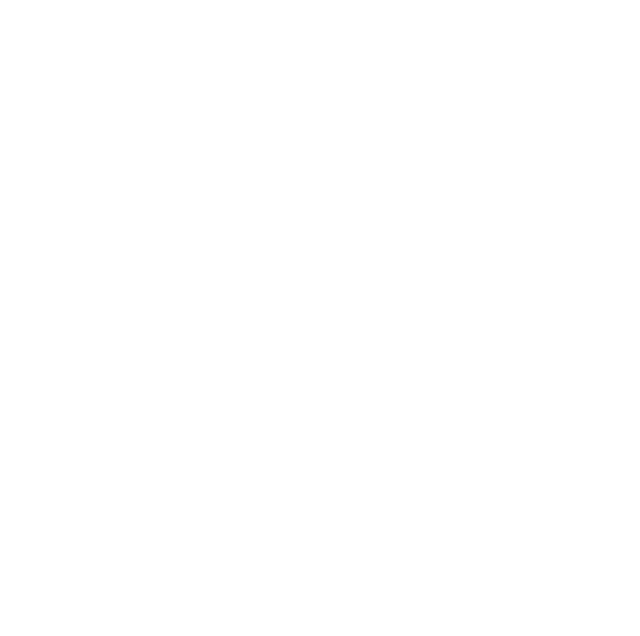

In [ ]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(np.transpose (make_grid(views2plot,padding=0).cpu(),(2,1,0)))